In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def sample(theta,eps,upper_bound=1,lower_bound=0,):
    def unif(t,s_lb,s_ub):
        if np.random.rand()>0.5:
            s = np.random.uniform(s_lb,t)
        else :
            s = np.random.uniform(t,s_ub)
        return s

    theta_proposed = np.zeros(len(theta))
    for i,t in enumerate(theta): 
        lower = max([t-eps[i]/2,lower_bound])
        upper = min([t+eps[i]/2,upper_bound])
        theta_proposed[i] = np.random.uniform(lower,upper,1)
    #if sum(theta_proposed)>1:
    scale_lb = max([sum(theta)-np.mean(eps),0])
    scale_ub = min([sum(theta)+np.mean(eps),1])
    theta_proposed = theta_proposed/sum(theta_proposed)*unif(sum(theta),scale_lb,scale_ub)
    return theta_proposed

In [3]:
dim=30
theta = np.random.rand(dim)
theta = theta/sum(theta)
eps = np.ones(dim)*0.2

#x = np.array([sample(theta,eps) for i in range(3000)])

In [52]:
thetas = []
for i in range(100000):
    theta = sample(theta,eps) 
    if sum(theta)>0:
        thetas.append(theta)
thetas = np.array(thetas)

In [53]:
len(thetas)

100000

(array([2.3055e+04, 1.2756e+04, 1.0421e+04, 8.8000e+03, 7.5550e+03,
        6.4140e+03, 5.4810e+03, 4.8100e+03, 4.1000e+03, 3.5680e+03,
        2.8860e+03, 2.4780e+03, 1.9990e+03, 1.6570e+03, 1.1400e+03,
        9.1500e+02, 6.6300e+02, 4.7200e+02, 3.2500e+02, 2.0300e+02,
        1.4100e+02, 6.8000e+01, 4.0000e+01, 2.5000e+01, 1.4000e+01,
        6.0000e+00, 3.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.21309711e-10, 3.58181867e-03, 7.16363721e-03, 1.07454558e-02,
        1.43272743e-02, 1.79090928e-02, 2.14909114e-02, 2.50727299e-02,
        2.86545485e-02, 3.22363670e-02, 3.58181856e-02, 3.94000041e-02,
        4.29818227e-02, 4.65636412e-02, 5.01454598e-02, 5.37272783e-02,
        5.73090968e-02, 6.08909154e-02, 6.44727339e-02, 6.80545525e-02,
        7.16363710e-02, 7.52181896e-02, 7.88000081e-02, 8.23818267e-02,
        8.59636452e-02, 8.95454638e-02, 9.31272823e-02, 9.67091008e-02,
        1.00290919e-01, 1.03872738e-01, 1.07454556e-01]),
 <BarContainer object of 30 

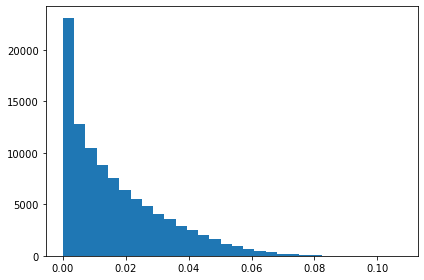

In [54]:
fig,ax = plt.subplots(tight_layout=True)
ax.hist(thetas[:,0],bins=30,)

(array([12649.,  9289.,  9373.,  9516.,  9260.,  9440.,  9595.,  9267.,
         9025., 12586.]),
 array([3.81641757e-09, 1.00000003e-01, 2.00000003e-01, 3.00000003e-01,
        4.00000002e-01, 5.00000002e-01, 6.00000001e-01, 7.00000001e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

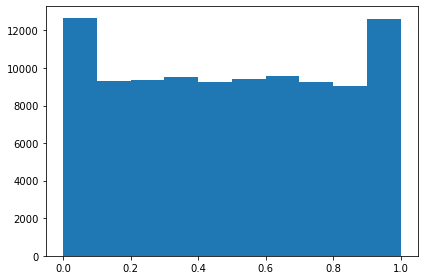

In [55]:
fig,ax = plt.subplots(tight_layout=True)
ax.hist(thetas.sum(axis=1))

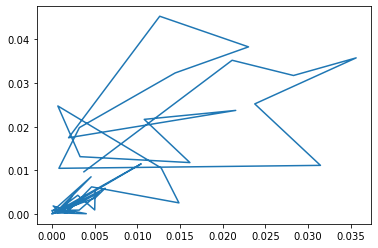

In [56]:
plt.figure()
plt.plot(thetas[:50,0],thetas[:50,1])

In [57]:
import pypsa

In [201]:
network = pypsa.Network('inter_results/network_c0_s1.nc')

INFO:pypsa.io:Imported network network_c0_s1.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [63]:

def extra_functionality(network, snapshots,variables,local_emis ):
    # Local emisons constraints 
    for i, bus in enumerate(variables):
        vars = []
        constants = []
        for t in network.snapshots: 
            for gen in network.generators.query('bus == {}'.format(str(bus))).index:
                vars.append(get_var(network,'Generator','p').loc[t,gen])
                const = 1/network.generators.efficiency.loc[gen] 
                const *= network.snapshot_weightings.loc[t]
                const *= network.carriers.co2_emissions.loc[network.generators.carrier.loc[gen]]

                constants.append(const)

        expr = linexpr((constants,vars)).sum()
        define_constraints(network,expr,'<=',local_emis[i],'local_co2','bus {}'.format(i))


In [161]:
solver = {
  "solver_name": 'gurobi',
  "formulation": 'kirchhoff',
  "pyomo": False,
  "keep_shadowprices": True,
  "solver_options": {
    "threads": 4,
    "method": 2, # barrier
    "crossover": 0,
    "BarConvTol": 1.e-6,
    "FeasibilityTol": 1.e-6,
    "AggFill": 0,
    "PreDual": 0,
    }}

In [75]:
from _mcmc_helpers import get_theta,calc_co2_emis_pr_node,read_csv
from pypsa.linopt import get_var, define_constraints, linexpr


In [339]:
co2_budget = 3875000
network.global_constraints.constant.CO2Limit = co2_budget

In [340]:
network.lopf(**solver,)
network.objective_optimum = network.objective 

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.59e+11


In [341]:
emis_pr_node = calc_co2_emis_pr_node(network)
plot_map(network,mcmc_variables,pd.Series(emis_pr_node))

In [342]:
gen_pr_node = network.generators_t.p.sum().groupby(network.generators.bus).sum()
plot_map(network,mcmc_variables,gen_pr_node)

In [343]:
network.carriers

,co2_emissions,color,nice_name
name,,,
onwind,0.000,#235ebc,Onshore Wind
offwind-ac,0.000,#6895dd,Offshore Wind (AC)
offwind-dc,0.000,#74c6f2,Offshore Wind (DC)
solar,0.000,#f9d002,Solar
PHS,0.000,#08ad97,Pumped Hydro Storage
hydro,0.000,#08ad97,Reservoir & Dam
ror,0.000,#4adbc8,Run of river
OCGT,0.187,#d35050,Open-Cycle Gas
H2,0.000,#ea048a,Hydrogen Storage


In [344]:
p_OCGT_pr_node = network.generators.query('carrier == "onwind"').p_nom_opt.groupby(network.generators.bus).sum()

In [345]:
plot_map(network,mcmc_variables,p_OCGT_pr_node)

In [328]:
theta = np.zeros(33) 
theta[0] = 0.5
co2_aloc = co2_budget * theta

In [329]:
mcmc_variables = read_csv(network.mcmc_variables)
extra_func = lambda n, s: extra_functionality(n,
                                            s,
                                            mcmc_variables,
                                            co2_aloc)

stat = network.lopf(**solver,
                    extra_functionality=extra_func)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 12.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+11


In [332]:
(network.objective-network.objective_optimum)/network.objective_optimum*100

20.191452319570203

In [194]:
calc_co2_emis_pr_node(network)

{'AL0 0': 0.0,
 'AT0 0': 0.0,
 'BA0 0': 0.0,
 'BE0 0': 0.0,
 'BG0 0': 0.0,
 'CH0 0': 0.0,
 'CZ0 0': 0.0,
 'DE0 0': 0.0,
 'DK0 0': 0.0,
 'DK3 0': 0.0,
 'EE6 0': 0.0,
 'ES0 0': 0.0,
 'ES2 0': 0.0,
 'FI3 0': 0.0,
 'FR0 0': 0.0,
 'GB4 0': 0.0,
 'GB5 0': 0.0,
 'GR0 0': 0.0,
 'HR0 0': 0.0,
 'HU0 0': 0.0,
 'IE4 0': 0.0,
 'IT0 0': 0.0,
 'IT1 0': 0.0,
 'LT6 0': 0.0,
 'LU0 0': 0.0,
 'LV6 0': 0.0,
 'ME0 0': 0.0,
 'MK0 0': 0.0,
 'NL0 0': 0.0,
 'NO3 0': 0.0,
 'PL0 0': 0.0,
 'PT0 0': 0.0,
 'RO0 0': 0.0,
 'RS0 0': 0.0,
 'SE3 0': 0.0,
 'SI0 0': 0.0,
 'SK0 0': 387499.9916243726}

In [203]:
network.generators.query('carrier == "onwind"').p_nom.sum()

0.0

In [204]:
network.generators.query('carrier == "OCGT"').p_nom.sum()

0.0

In [251]:
c_links = sum((network.links.p_nom_opt - network.links.p_nom)*network.links.capital_cost)
c_gen = sum(network.generators.p_nom_opt*network.generators.capital_cost)
c_store = sum(network.storage_units.p_nom_opt*network.storage_units.capital_cost)
c_marg = sum(network.generators_t.p.sum() * network.generators.marginal_cost)
c_lines = sum((network.lines.s_nom_opt-network.lines.s_nom) * network.lines.capital_cost)

In [236]:
c_links + c_gen + c_marg + c_store

205143240030.3206

In [237]:
network.objective

222528806351.01373

In [252]:
(c_links + c_gen + c_marg + c_store + c_lines - network.objective)/network.objective * 100

-5.393622762746418

(<matplotlib.collections.PatchCollection at 0x7fc263cb02d0>,
 <matplotlib.collections.LineCollection at 0x7fc26455e1d0>)

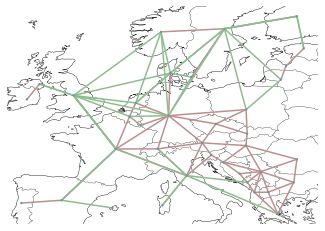

In [182]:
network.plot()

In [349]:
network.generators_t.p_max_pu.sum().groupby(network.generators.bus).sum()

bus
AL0 0     32.684876
AT0 0     22.290335
BA0 0     15.980941
BE0 0    136.339592
BG0 0     77.409737
CH0 0     12.255156
CZ0 0     24.808720
DE0 0    129.845252
DK0 0    154.205898
DK3 0    149.274982
EE6 0    117.191206
ES0 0     90.658678
ES2 0     87.505979
FI3 0    114.559020
FR0 0    117.997027
GB4 0    160.730693
GB5 0    145.450168
GR0 0     90.530969
HR0 0     65.453093
HU0 0     28.378375
IE4 0    152.936179
IT0 0     69.388862
IT1 0     57.474398
LT6 0    115.772049
LU0 0     29.196200
LV6 0    116.890635
ME0 0     30.208814
MK0 0     15.352349
NL0 0    148.014902
NO3 0    106.208894
PL0 0    123.339108
PT0 0     59.772758
RO0 0     94.512084
RS0 0     24.972825
SE3 0    117.997087
SI0 0     32.822191
SK0 0     25.577328
dtype: float64

In [200]:
network.generators_t.p_max_pu

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE3 0 offwind-ac,SE3 0 offwind-dc,SE3 0 onwind,SE3 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
name,,,,,,,,,,,,,,,,,,,,,
2013-01-08 14:00:00,0.104030,0.008850,0.176494,0.027312,0.035381,0.003418,0.066643,0.625623,0.770775,0.105219,...,0.076210,0.142029,0.244284,0.118701,0.000000,0.000000,0.003298,0.025734,0.004036,0.022944
2013-01-11 12:00:00,0.009708,0.000000,0.088067,0.228416,0.206608,0.001074,0.101693,0.063125,0.098096,0.011150,...,0.211100,0.713902,0.831612,0.342236,0.076182,0.000000,0.004344,0.252514,0.227288,0.063458
2013-01-14 11:00:00,0.745119,0.291819,0.084507,0.017040,0.124318,0.230614,0.094220,0.235002,0.188974,0.044089,...,0.128927,0.279079,0.393589,0.119179,0.076451,0.258283,0.016751,0.050491,0.286089,0.050425
2013-01-17 00:00:00,0.191894,0.058524,0.000000,0.103001,0.000000,0.013546,0.000000,0.000000,0.000000,0.075448,...,0.000000,0.198893,0.406696,0.084706,0.000000,0.433387,0.080965,0.000000,0.151205,0.000000
2013-01-31 07:00:00,0.008165,0.011500,0.210284,0.780333,0.031341,0.048628,0.089148,1.000000,1.000000,0.899862,...,0.033923,0.744942,0.708790,0.362591,0.000000,0.000000,0.051613,0.128343,0.643181,0.114183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-18 19:00:00,0.000000,0.000000,0.000000,0.017505,0.000000,0.000000,0.000000,1.000000,1.000000,0.945912,...,0.000000,0.521092,0.545906,0.235807,0.000000,0.000000,0.000000,0.000000,0.025475,0.000000
2013-12-21 02:00:00,0.020913,0.000681,0.000000,0.066866,0.000000,0.002810,0.000000,1.000000,1.000000,0.895568,...,0.000000,0.781851,0.948886,0.362982,0.000000,0.000000,0.000000,0.000000,0.063145,0.000000
2013-12-22 14:00:00,0.000000,0.000000,0.140090,0.012358,0.073170,0.012870,0.129617,1.000000,1.000000,0.992665,...,0.095433,0.910721,0.963419,0.556632,0.002769,0.031090,0.096377,0.082333,0.076042,0.007073


In [268]:
gen_pr_node

bus
AL0 0    2.169763e-01
AT0 0    1.729552e-01
BA0 0    1.661397e-01
BE0 0    1.386392e+05
BG0 0    1.902989e-01
CH0 0    1.747542e-01
CZ0 0    1.194026e+04
DE0 0    9.149314e+05
DK0 0    2.439184e+06
DK3 0    3.922540e+05
EE6 0    9.435269e+04
ES0 0    3.148542e+06
ES2 0    4.682976e+04
FI3 0    8.279950e+05
FR0 0    1.949642e+06
GB4 0    1.413016e+06
GB5 0    1.139447e+07
GR0 0    1.991310e+06
HR0 0    1.147374e+04
HU0 0    8.150871e+05
IE4 0    2.501558e+06
IT0 0    1.642886e+06
IT1 0    1.143327e+05
LT6 0    7.228674e+04
LU0 0    2.198126e-01
LV6 0    6.525896e+04
ME0 0    1.704554e-01
MK0 0    1.598387e-01
NL0 0    7.606964e+05
NO3 0    2.003960e+06
PL0 0    1.834168e+06
PT0 0    1.937137e-01
RO0 0    5.429724e+05
RS0 0    1.843985e+05
SE3 0    6.713559e+05
SI0 0    5.228383e-01
SK0 0    1.806378e-01
dtype: float64

In [322]:
def plot_map(network,mcmc_variables,pr_node_series):
    from iso3166 import countries
    import plotly.graph_objects as go 
    import pypsa
    from _mcmc_helpers import calc_co2_emis_pr_node, read_csv


    agg_series = {}
    for i in range(33):
        alpha2_mcmc_variable = mcmc_variables[i][0][:2]
        alpha3 = countries.get(alpha2_mcmc_variable).alpha3
        try :
            agg_series[alpha3] += sum(pr_node_series [mcmc_variables[i]].values)
        except : 
            try :
                agg_series[alpha3] = sum(pr_node_series [mcmc_variables[i]].values)
            except : 
                agg_series[alpha3] = 0 


    fig = go.Figure()
    fig.add_trace(go.Choropleth(
                        geo='geo1',
                        locations = list(agg_series.keys()),
                        z = list(agg_series.values()),#/area,
                        text = list(agg_series.keys()),
                        colorscale = 'Thermal',
                        autocolorscale=False,
                        #zmax=283444,
                        zmin=0,
                        reversescale=False,
                        marker_line_color='darkgray',
                        marker_line_width=0.5,
                        #colorbar_tickprefix = '',
                        #colorbar_title = 'Potential [MWh/km^2]'
                            )) 
    fig.update_geos(
            scope = 'europe',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
            lataxis = dict(
                range = [35, 64],
                showgrid = False
            ),
            lonaxis = dict(
                range = [-11, 26],
                showgrid = False
            )
        ),

    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )


    fig.show()